<a href="https://colab.research.google.com/github/JMGO-coding/MLX_academic_performance/blob/develop/src/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *PROJECT TASK*

The goal of practical project is to explain, using all techniques explained in class, the ML
models assigned.
At least each team must explain 2 ML models (a.k.a. compulsory models). Additionally,
the team can build and explain a third model (a.k.a. extra model).

The Practical Project will consist of:

- Python 2 or 3 notebooks: ipynb file for each model.
- Dataset: csv file or online load hardcoded.

Each notebook must include:

- Markdown use:
    - Sections and subsections numbered (using #, ##, etc.)
    - Concise and clear descriptions of the decisions made
    - Concise and clear conclusions of the explanations obtained.

- The code must be clear and must include comments.
- The notebook must include 3 sections (you can add subsections):

1. Dataset load and preparation
2. ML model training
3. ML explanation

The ML explanation, section 3, is the most important part of the project. Here you should
cover:

- Use any explanation method useful that you’ve seen on class.
- Provide individual explanations of instance. Not just plots, but the conclusions
you can make.
- Provide global explanations of the ML model. Not just plots, but the conclusions
you can make.

# Machine Learning Explicable. Explicación de un SVC.

## 0. Requerimientos y funciones auxiliares

In [ ]:
%%capture

COLAB = False # TODO: True para ejecutar notebook en Colab
INSTALL = COLAB # TODO: True para instalaciones en Colab
PROFILING = False # True para pruebas más pequeñas

if INSTALL:
    %pip install supertree
    %pip install dill
    %pip install shap
    %pip install lime

In [2]:
CLONE = COLAB
if CLONE:
  !git clone https://github.com/JMGO-coding/MLX_academic_performance.git

In [3]:
# Importación de librerías
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
import random
import supertree

import os
import sys
import datetime

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#from skopt import BayesSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import OneHotEncoder
import sklearn.impute as impute

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import plot_tree

from sklearn.pipeline import Pipeline
from scipy import stats

# Regresión

# Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA

# Desbalanceo
#from imblearn.over_sampling import SVMSMOTE, RandomOverSampler, ADASYN
#from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
#from imblearn.ensemble import RUSBoostClassifier
#from sklearn.
# import OneClassSVM

# Modelos de clasificación

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from xgboost import XGBRegressor
import joblib
import dill # salvado de modelos en pickle

import lime
import shap


In [4]:
# Añadir los directorio fuentes al path de Python
if COLAB:
  sys.path.append('/content/MLX_academic_performance/src')
else:
  sys.path.append('./src')

In [5]:
#@title Guardado de modelos

model_path = "./models/smv.pkl" if not COLAB else "/content/MLX_academic_performance/src/models/smv.pkl"

def save_model(model, model_path=model_path):
    with open(model_path, "wb") as f:
        dill.dump(model, f)

def load_model(model_path=model_path):
    with open(model_path, "rb") as f:
        return dill.load(f)

## 1. Carga y preprocesamiento del dataset

### 1.1. Primeras visualizaciones y estadísticas

In [6]:
# Fijamos la semilla y los directorios

SEED = 2024

random.seed(SEED)
np.random.seed(SEED)

directory = '/content/MLX_academic_performance' if COLAB else '../'
plots_directory = os.path.join(directory, 'plots/')
data_directory = os.path.join(directory, 'data/')

Usamos el dataset *Predict Students' Dropout and Academic Success*, creado por una institución portuguesa de educación superior, que contiene información sobre estudiantes matriculados en diferentes licenciaturas (como agronomía, diseño, educación, enfermería, periodismo, gestión, servicios sociales o tecnología). El objetivo principal es predecir el abandono y el éxito académico de los estudiantes mediante modelos de clasificación.

Incluye información demográfica, socioeconómica y académica del estudiante al momento de la matrícula, así como su rendimiento académico al final del primer y segundo semestre. El problema se formula como una tarea de clasificación de tres categorías: abandono, matriculado y graduado, al final de la duración normal del curso.

In [7]:
# Lectura del Dataset y primera visualización

data_file = 'data.csv'
data_path = data_directory + data_file
df= pd.read_csv(data_path, sep=';')
print(df.shape)
df.head()

(4424, 37)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [8]:
# Limpiar los nombres de las columnas
df.columns = df.columns.str.strip()  # Eliminar espacios al principio y al final

In [9]:
df.info()   # Conteo de no-nulos y data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

El dataset no contiene valores nulos. Además, hay 29 columnas con tipo de dato `int64` representando variables categóricas y  variables numéricas discretas, 7 columnas de tipo `float64` representando variables numéricas continuas, como calificaciones y tasas, y una columna de tipo `object` que representa la variable objetivo y contiene las categorías de clasificación (abandono, matriculado y graduado).

Para facilitar el preprocesamiento y el estudio de las variables, las separamos en distintas listas según su tipo.

In [10]:
# Variables según su tipo
qualification_features = ['Previous qualification', 'Mother\'s qualification', 'Father\'s qualification']
thres_features = ['Marital status', 'Application mode', 'Course', 'Mother\'s occupation', 'Father\'s occupation']

categorical_features = thres_features + qualification_features + ['Nacionality']   # Variables categóricas

numerical_features = ['Application order', 'Previous qualification (grade)',
                      'Admission grade', 'Age at enrollment',
                      'Curricular units 1st sem (credited)',  'Curricular units 1st sem (enrolled)',  'Curricular units 1st sem (evaluations)',
                      'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)',  'Curricular units 1st sem (without evaluations)',
                      'Curricular units 2nd sem (credited)',  'Curricular units 2nd sem (enrolled)',  'Curricular units 2nd sem (evaluations)',
                      'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)',  'Curricular units 2nd sem (without evaluations)',
                      'Unemployment rate', 'Inflation rate', 'GDP'
                    ]   # Variables numéricas

binary_features = ['Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender',
                   'Scholarship holder', 'International']   # Variables binarias

target_feature = 'Target' # Variable objetivo, categórica con 3 clases

Observando el histograma para la variable `Target` vemos que hay desequilibrio entre las clases, con una mayor cantidad de graduados, y menor de matriculados.

## 1.2. Selección de características

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

selection = False # True para realizar selección de características

selected_features = categorical_features + numerical_features + binary_features

if selection:
    # Definir variables predictoras y objetivo
    X = df.drop(columns=['Target']).copy()  # Reemplaza 'target' con el nombre de tu variable objetivo
    y = df['Target'].copy()

    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Estandarización de los datos (opcional, útil para algunos modelos)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Construir el modelo de Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Evaluar modelo
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Obtener la importancia de las características
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    # Visualizar las características más importantes
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
    plt.xlabel("Importancia")
    plt.ylabel("Característica")
    plt.title("Importancia de las características en Random Forest")
    plt.gca().invert_yaxis()
    plt.show()

    # Selección de características más importantes (puedes ajustar el umbral)
    selected_features = feature_importances[feature_importances['importance'] > 0.02]['feature'].tolist()

print("Características seleccionadas:", selected_features)

Características seleccionadas: ['Marital status', 'Application mode', 'Course', "Mother's occupation", "Father's occupation", 'Previous qualification', "Mother's qualification", "Father's qualification", 'Nacionality', 'Application order', 'Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP', 'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Internat

In [12]:
# Filtramos las listas de features tras la seleccion

selected_features += ['Target'] # Añadimos el target

qualification_features = [feat for feat in selected_features if feat in qualification_features]
thresh_features = [feat for feat in selected_features if feat in thres_features]
categorical_features = [feat for feat in selected_features if feat in categorical_features]
numerical_features = [feat for feat in selected_features if feat in numerical_features]
binary_features = [feat for feat in selected_features if feat in binary_features]

### 1.3. Transformación de variables categóricas

*   Elemento de lista
*   Elemento de lista



En este apartado del preprocesamiento, aplicamos una serie de transformaciones a las variables categóricas del dataset, para facilitar la construcción del modelo. Algunas de estas variables contienen un gran número de categorías, por lo que para poder tratarlas de forma más eficiente, se van a agrupar dichas categorías en un menor número de categorías más generales.

En primer lugar, definimos una función `transformar_nivel_estudios`, que utilizamos para agrupar todas las categorías relacionadas con el nivel de estudios del estudiante y de sus padres en cuatro grupos más generales: "Incompleta", "Secundaria", "Superior Técnica" y "Universitaria".

In [13]:
def transformar_nivel_estudios(valor):
    """
    Transforma el nivel de estudios de un número entero a una de las cuatro nuevas categorías.
    """
    no_secundaria = {11, 26, 27, 38, 19, 12, 14, 15, 10, 9, 6, 29, 30, 35, 36, 37, 13, 20, 25}
    secundaria_completa = {1}
    superior_tecnico = {22, 39, 42, 18, 31, 33}
    superior_universitario = {2, 3, 4, 5, 40, 43, 44, 41}

    if valor in no_secundaria:
        return 0 # "Incompleta"
    elif valor in secundaria_completa:
        return 1 # "Secundaria"
    elif valor in superior_tecnico:
        return 2 # "Superior Técnica"
    elif valor in superior_universitario:
        return 3 # "Universitaria"
    else:
        return -1 # "Otro"

dict_study_level = {0: "Incompleta", 1: "Secundaria", 2: "Superior Técnica", 3: "Universitaria", -1: "Otro"}

def get_clase_estudios(n : int):
    return dict_study_level[n]

In [14]:
qualification_features = ['Previous qualification', 'Mother\'s qualification', 'Father\'s qualification']

for feature in qualification_features:
    df[feature] = df[feature].apply(transformar_nivel_estudios)

A continuación, como la variable `Nacionality` también contiene muchas categorías diferentes, y además la mayoría de ellas están representadas por un número muy reducido de instancias, hemos decidido cambiarla por una variable binaria llamada `foreign`. En esta nueva variable, 0 indica que el estudiante es de nacionalidad portuguesa y 1 que es extranjero.

In [15]:
# Transformar variables enteras a categóricas
df['foreign'] = df['Nacionality'].map(lambda x: 0 if x == 1 else 1)

if 'Nacionality' in selected_features:
  selected_features.remove('Nacionality')
  selected_features += ['foreign']

  binary_features += ['foreign']
  categorical_features.remove('Nacionality')

df.drop(columns=['Nacionality'], inplace=True)

Para manejar aquellas categorías con baja frecuencia, en algunas columnas categóricas se ha usado un umbral del $5\%$ para agrupar las categorías con frecuencias muy bajas en una categoría general -1 (equivale a una clase ``otro''). Gracias a este paso, disminuimos el número de categorías en dichas variables.

In [16]:
# 5% threshold for categorical features

threshold = 0.05

for feature in thres_features:
    value_counts = df[feature].value_counts(normalize=True)
    if value_counts.max() > threshold:
        df[feature] = df[feature].apply(lambda x: x if value_counts[x] > threshold else -1) # -1 = other

Por último, creamos histogramas para observar la nueva distribución de las variables categóricas tras haber realizado las transformaciones.

Ahora, se convierten las variables categóricas a tipo `category`.

In [17]:
#for feature in categorical_features:
#    df[feature] = df[feature].astype('category') #  other

### 1.4. Partición de los datos en *Train* y *Test*

Particionamos los datos en un conjunto de *train* del $90\%$ que usaremos para entrenar el modelo, y un conjunto de *test* del $10\%$ que usaremos para evaluar el modelo ya entrenado, comprobando su capacidad de generalización a nuevos datos, y evaluando que no haya overfitting.

In [18]:
df_raw = df.copy()
df = df[selected_features]

In [19]:
# Definir el mapeo
target_mapping = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}         # Reemplaza con los valores reales
inverse_target_mapping = {v: k for k, v in target_mapping.items()}    # Crea el mapeo inverso

# Aplicar el mapeo a la columna 'Target'
df['Target'] = df['Target'].map(target_mapping)

# Verificar el resultado
print(df['Target'].value_counts())  # Ver distribución de clases

Target
2    2209
0    1421
1     794
Name: count, dtype: int64


In [20]:

X = df.drop(columns=['Target'])
y = df['Target']
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=SEED)

print("Tamaño train:", len(X_train))
print("Tamaño test:", len(X_test))

Tamaño train: 3981
Tamaño test: 443


### TODO: Selección de características

In [21]:
selection = False

if selection:
  # Selección de características para la etiqueta actual
  selector = SelectKBest(f_classif, k='all')
  selector.fit(X, y['Target'])

### TODO: Outliers

In [22]:
outliers = False

if outliers:
  # Creamos un DataFrame con las puntuaciones promediadas
  features_df = pd.DataFrame({
      "Feature": X.columns,
      "Score": selector.scores_
  }).sort_values(by="Score", ascending=False)

  print(features_df)

  # Filtramos por umbral
  threshold = 5  # Puntuación mínima aceptable
  selected_features = features_df[features_df["Score"] > threshold]["Feature"]

  # Creamos nuevos conjuntos de datos con las características seleccionadas
  X_train = X_train[selected_features]
  X_test = X_test[selected_features]

## 2. Entrenamiento del modelo (SVM)


En este apartado, entrenamos un modelo de árbol de decisión utilizando un *Pipeline* que incorpora tanto un procesamiento de las variables como la búsqueda de los mejores hiperparámetros mediante *Grid Search*.

El preprocesamiento que se aplica a las variables depende del tipo. A las variables categóricas se les aplica *One Hot Encoding*, convirtiéndolas en columnas binarias que representan las características de cada variable. Por otro lado, a las características binarias se les aplica un `FunctionTransformer` para asegurar que los datos sean procesados correctamente en el *Pipeline*.

In [ ]:
LOAD = True

model_path = './models/svm.pkl' if not COLAB else '/content/MLX_academic_performance/src/models/svm.pkl'
results_path = './results/svm-grid.csv' if not COLAB else '/content/MLX_academic_performance/src/results/svm-grid.csv'

# Preprocesamiento por tipo de variable
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaler', StandardScaler(), numerical_features),
    ('binary', FunctionTransformer(lambda x: x if x.ndim > 1 else x[:, None]), binary_features)
])

# Aplicar SMOTE o RandomUnderSampler solo en el conjunto de entrenamiento
#sampler = RandomUnderSampler(random_state=SEED)  # O SMOTE(), SVMSMOTE(), ADASYN()

svm = SVC(random_state=SEED, probability=True)
    # probability=True para obtener probabilidades en la predicción, lo que facilita la explicación del modelo


# Pipeline completo
svm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier',svm)
])

In [24]:
if not LOAD:
    # Ejecutamos un Grid search y nos quedamos con el modelo de mejores hiperparámetros

    param_grid = {
        'classifier__C': [0.1, 1, 10, 100],        # Regularización
        'classifier__gamma': [0.01, 0.1, 0.5],  # Coeficiente del kernel
        'classifier__kernel': ['rbf', 'sigmoid']   # Kernel
    }

    grid_search = GridSearchCV(svm_model, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, refit=True)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    save_model(best_model, model_path) # Guardamos el mejor modelo
    
    results = pd.DataFrame(grid_search.cv_results_)
    results.to_csv(results_path, index=False)
else:
    best_model = load_model(model_path)
    results = pd.read_csv(results_path)

y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Mejores parámetros:", grid_search.best_params_)
print("F1-score en test:", f1)

Mejores parámetros: {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
F1-score en test: 0.7645820837527278


In [25]:
# @title Mejores combinaciones de hiperparámetros
results = results.sort_values(by='rank_test_score')
display(results[['param_classifier__C', 'param_classifier__gamma', 'param_classifier__kernel', 'mean_test_score']].head())

,param_classifier__C,param_classifier__gamma,param_classifier__kernel,mean_test_score
12,10.0,0.01,rbf,0.768393
6,1.0,0.01,rbf,0.753851
18,100.0,0.01,rbf,0.746359
8,1.0,0.10,rbf,0.739612
20,100.0,0.10,rbf,0.734826


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       142
           1       0.56      0.38      0.45        80
           2       0.81      0.90      0.85       221

    accuracy                           0.78       443
   macro avg       0.72      0.69      0.70       443
weighted avg       0.76      0.78      0.76       443



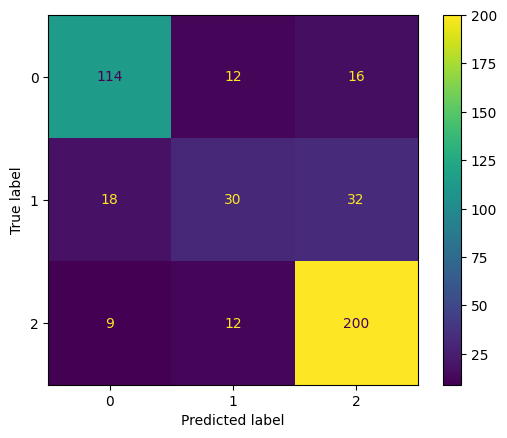

In [27]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show()

In [28]:
# @title Guardar modelo

save_model(best_model, model_path="./models/SVM.pkl")

## 3. Explicación del modelo

El modelo SVC se basa en discriminantes sobre un espacio de características transformado por una función kernel.

In [29]:
print(X_test.dtypes)

Marital status                                      int64
Application mode                                    int64
Course                                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Previous qualification                              int64
Mother's qualification                              int64
Father's qualification                              int64
Application order                                   int64
Previous qualification (grade)                    float64
Admission grade                                   float64
Age at enrollment                                   int64
Curricular units 1st sem (credited)                 int64
Curricular units 1st sem (enrolled)                 int64
Curricular units 1st sem (evaluations)              int64
Curricular units 1st sem (approved)                 int64
Curricular units 1st sem (grade)                  float64
Curricular uni

In [ ]:
TAM_SHAP = 250 if not PROFILING else 25

#@title Build Shap Explainer
X_sub = shap.sample(X_train, 250)
ex = shap.Explainer(best_model.predict_proba, X_sub, output_names=['Dropout', 'Enrolled', 'Graduate'])

PermutationExplainer explainer: 251it [11:26,  2.77s/it]                         


In [ ]:
#@title Compute Shap Values
shap_values_path = './results/shap-values-svm.pkl' if not COLAB else '/content/MLX_academic_performance/src/results/shap-values-svm.pkl'
if not LOAD:
    shap_values = ex(X_test[:250])
    save_model(shap_values, model_path=shap_values_path)
else:
    shap_values = load_model(model_path=shap_values_path)

### Waterfall plot

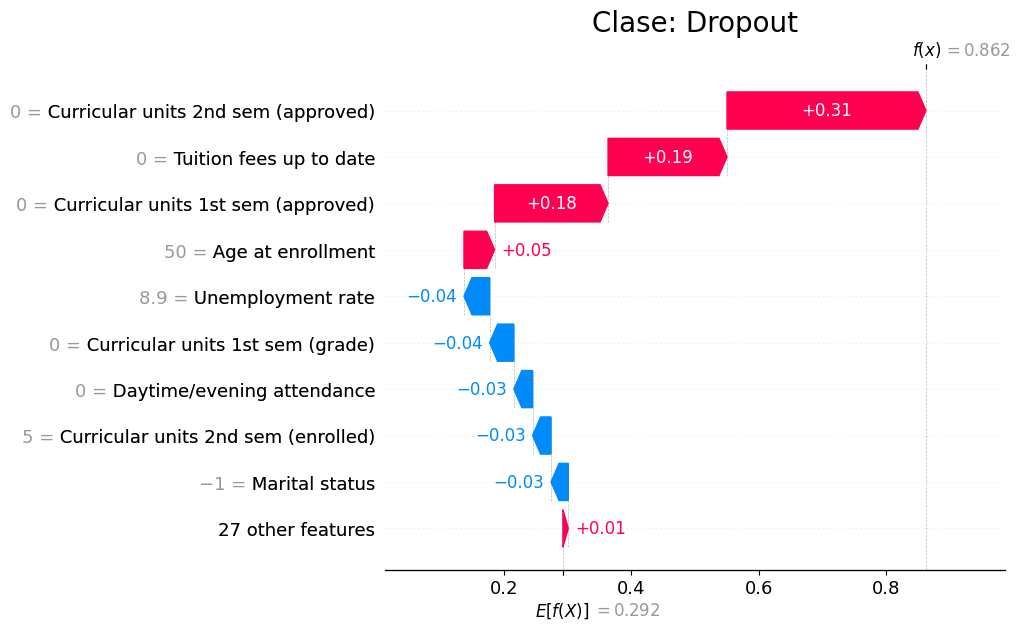

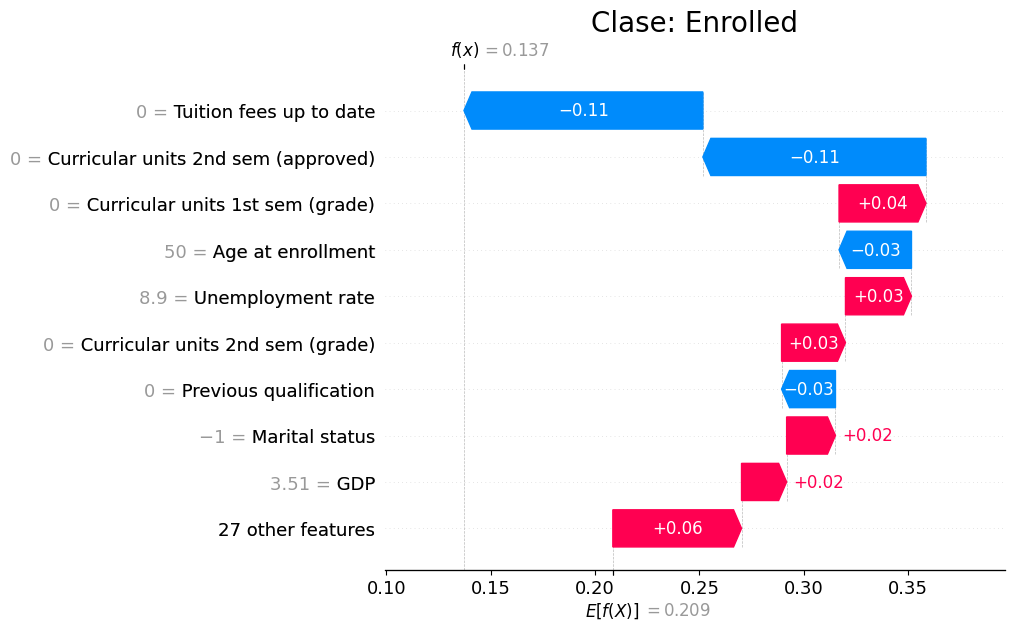

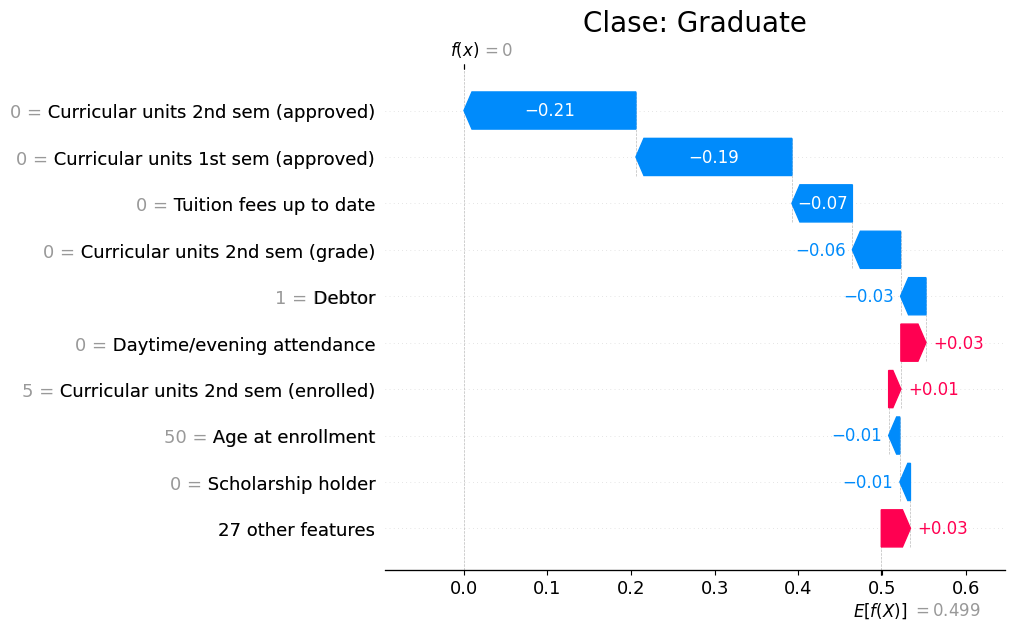

In [37]:
data_index = 2

for class_index in range(3):
    # title
    plt.title("Clase: " + inverse_target_mapping[class_index], fontsize=20)
    shap.plots.waterfall(shap_values[data_index,:,class_index])

### Bee Swarm plot

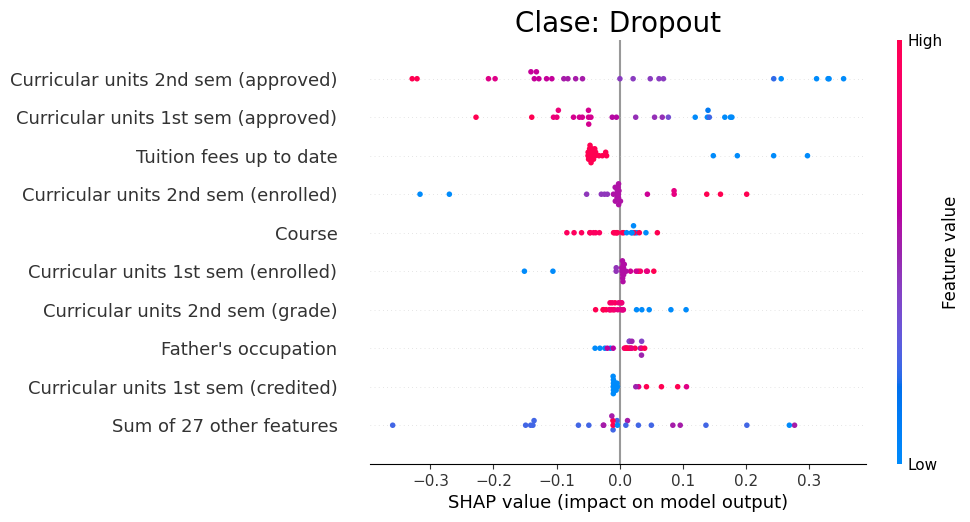

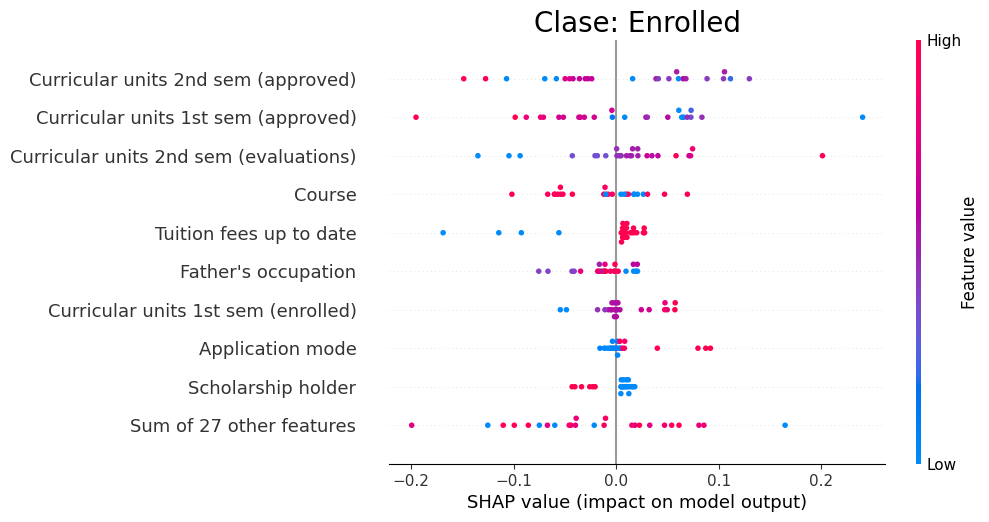

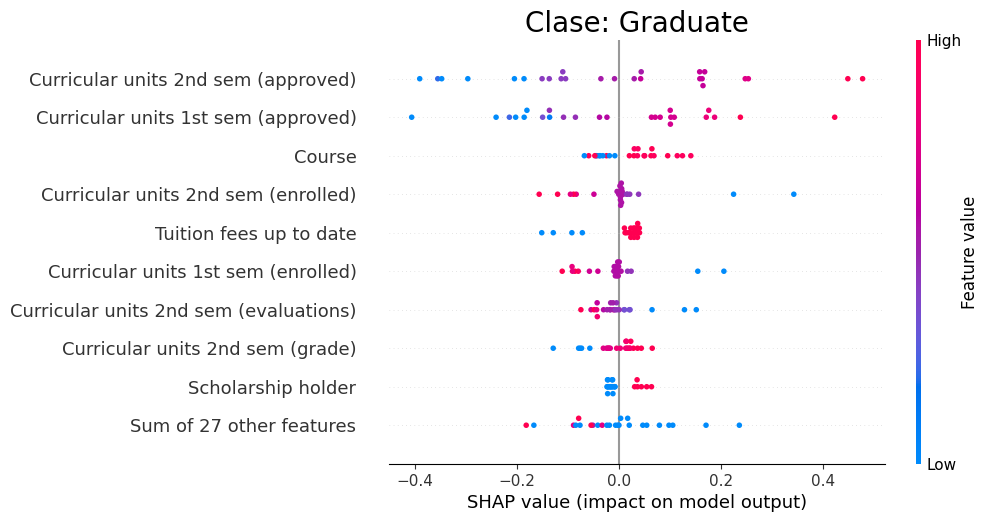

In [42]:
for class_index in range(3):
    plt.title("Clase: " + inverse_target_mapping[class_index], fontsize=20)
    shap.plots.beeswarm(shap_values[:,:,class_index])

### Scatter Plot

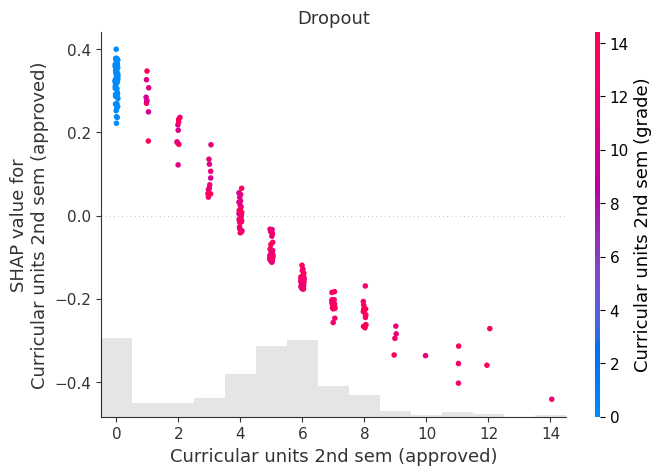

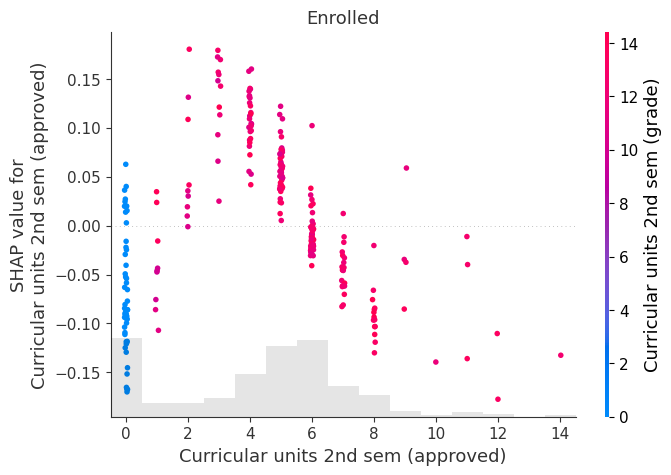

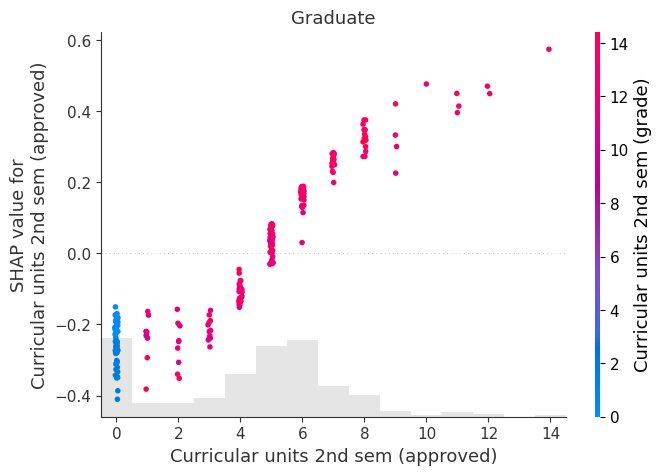

In [63]:
for class_index in range(3):
    shap.plots.scatter(shap_values[:, 'Curricular units 2nd sem (approved)', class_index], color=shap_values[:, 'Curricular units 2nd sem (grade)', class_index], title=inverse_target_mapping[class_index])